In [1]:
import scipy.io
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import numpy as np
from numpy import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
data_dict = {'Lung_Lesion': 0,
 'Atelectasis': 1,
 'No_Finding': 2,
 'Edema': 3,
 'Lung_Opacity': 4,
 'Cardiomegaly': 5,
 'Pleural_Other': 6,
 'Fracture': 7,
 'Pneumonia': 8,
 'Enlarged_Cardiomediastinum': 9,
 'Pleural_Effusion': 10,
 'Pneumothorax': 11,
 'Support_Devices': 12,
 'Consolidation': 13}

In [25]:
def _load_image(path):
    image = cv2.imread(path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image.astype(np.float32)
    return None

In [26]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [27]:
def _build_examples_list(input_folder, seed):
    examples = []
    for classname in os.listdir(input_folder):
        class_dir = os.path.join(input_folder, classname)
        if (os.path.isdir(class_dir)):
            for filename in os.listdir(class_dir):
                filepath = os.path.join(class_dir, filename)
                example = {
                    'classname': classname, 
                    'path': filepath,
                    'label': data_dict[classname]
                }
                examples.append(example)

    random.seed(seed)
    random.shuffle(examples)
    return examples

In [28]:
def _split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts] 
             for i in range(wanted_parts) ]

In [29]:
def _get_examples_share(examples, training_split):
    examples_size = len(examples)
    len_training_examples = int(examples_size * training_split)

    return np.split(examples, [len_training_examples])

In [30]:
def _write_tfrecord(examples, output_filename):
    writer = tf.io.TFRecordWriter(output_filename)
    for example in tqdm(examples):
        try:
            image = _load_image(example['path'])
            if image is not None:
                encoded_image_string = cv2.imencode('.jpg', image)[1].tostring()
                feature = {
                    'label': _bytes_feature(tf.compat.as_bytes(str(example['label']))),
                    'image': _bytes_feature(tf.compat.as_bytes(encoded_image_string)),
                    'classname': _bytes_feature(tf.compat.as_bytes(example['classname']))
                }

                tf_example = tf.train.Example(features = tf.train.Features(feature=feature))
                writer.write(tf_example.SerializeToString())
        except Exception as inst:
            print(inst)
            pass
    writer.close()

In [31]:
def _write_sharded_tfrecord(examples, number_of_shards, base_output_filename, is_training = True):
    sharded_examples = _split_list(examples, number_of_shards)
    for count, shard in tqdm(enumerate(sharded_examples, start = 1)):
        output_filename = '{0}_{1}_{2:02d}of{3:02d}.tfrecord'.format(
            base_output_filename,
            'train' if is_training else 'test',
            count,
            number_of_shards 
        )
        _write_tfrecord(shard, output_filename)

In [32]:
#list of dictionaries {classname:'' , path:''}
train_list = _build_examples_list(r'/home/scott/CSE6250/Data', 123)

In [33]:
training_examples, test_examples = _get_examples_share(train_list,0.8)

In [35]:
print("Creating training shards", flush = True)
_write_sharded_tfrecord(training_examples, number_of_shards=2, base_output_filename='/home/scott/CSE6250/tfrecords/')

| 8127/13106 [00:59<00:34, 142.87it/s]
100%|██████████| 13106/13106 [01:36<00:00, 135.51it/s]
2it [03:20, 100.14s/it]


# Data Input Pipeline

In [3]:
def resize_(img, lab):
    img = tf.image.resize(img, [299,299])
    return img, lab

def parse_fn(example):
  "Parse TFExample records and perform simple data augmentation."
  example_fmt = {
    'image': tf.io.FixedLenFeature((), tf.string, ""),
    'label': tf.io.FixedLenFeature((), tf.string, ""),
    'classname': tf.io.FixedLenFeature((), tf.string, "")
  }
  parsed = tf.io.parse_single_example(example, example_fmt)
  image = tf.io.decode_jpeg(parsed["image"])
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [299,299])

  idx = int(parsed['label'])
  depth = 13
  label = tf.one_hot(idx, depth)
  return image, label, parsed["classname"]

def make_dataset():
  files = tf.data.Dataset.list_files("/home/scott/CSE6250/tfrecords/*.tfrecord")
  dataset = files.interleave(
    tf.data.TFRecordDataset, cycle_length=1,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size=500)
  dataset = dataset.map(map_func=parse_fn)
  dataset = dataset.batch(batch_size=10)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset

# Model

In [21]:
from AutoEncoder.CheXpert import XrayAE_Functional

In [22]:
model = XrayAE_Functional()

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 64)    3072      
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 128)   131584    
_________________________________________________________________
sequential_2 (Sequential)    (None, None, None, 256)   525312    
_________________________________________________________________
sequential_3 (Sequential)    (None, None, None, 512)   2099200   
_________________________________________________________________
sequential_4 (Sequential)    (None, None, None, 512)   4196352   
_________________________________________________________________
sequential_5 (Sequential)    (None, None, None, 512)   419635

In [9]:
data = make_dataset()

In [10]:
for img, lab, classname in data.take(1):
    img = img
    lab = lab
    classname = classname

In [23]:
output = model(img, training=True)

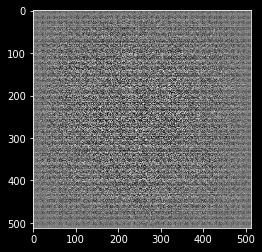

In [20]:
plt.figure()
plt.imshow(np.squeeze(output[0]), cmap='gray')
plt.show()

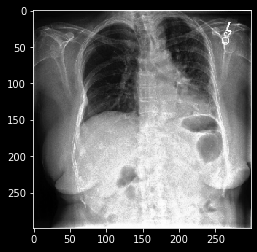

In [16]:
plt.figure()
plt.imshow(np.squeeze(img[0]), cmap='gray')
plt.show()